**This training is based on the dataset:** https://drive.google.com/file/d/1gmHh4Jhyt_FHG_7LQmXubFa27VElwbZz/view?usp=sharing 

### **For ease of review, here I have combined the.py files,.txt files, etc., into one.ipynb file**

**The following process just need to do once to create classes.txt.**

**classes.txt: Match the numbers to the names of the fruits and vegetables **

# *classes.txt*

Apple
Apricot
Avocado
Banana
Beetroot
Blueberry
Cabbage
Cactus fruit
Cantaloupe
Carambula
Carrot
Cauliflower
Cherry
Chestnut
Chilli Pepper
Choy
Clementine
Cocos
Corn
Corn Husk
Cucumber
Dates
Eggplant
Fig
Garlic
Ginger
Granadilla
Grape
Grapefruit
Guava
Hazelnut
Huckleberry
Jalapeno
Kaki
Kiwi
Kohlrabi
Kumquats
Lemon
Lettuce
Limes
Lychee
Mandarine
Mango
Mangostan
Maracuja
Melon Piel de Sapo
Mulberry
Napa Cabbage
Nectarine
Nectarine Flat
Nut Forest
Nut Pecan
Onion
Orange
Papaya
Passion Fruit
Pea
Peach
Pear
Pepino
Pepper
Physalis
Physalis with Husk
Pineapple
Pitahaya Red
Plum
Pomegranate
Pomelo
Potato
Quince
Radish
Rambutan
Raspberry
Redcurrant
Salak
Soy Beans
Spinach
Strawberry
Tamarillo
Tangelo
Tomato
Turnip
Walnut
Watermelon

In [ ]:
import os

with open('classes.txt', 'w+') as f:
    f.write('\n'.join(os.listdir('train')))

for idx, i in enumerate(os.listdir('train')):
    os.rename('train\{}'.format(i), 'train\{}'.format(idx))
    os.rename('test\{}'.format(i), 'test\{}'.format(idx))

**Data argumentation**

In [ ]:
import cv2, os, math, random, torch
import numpy as np
from torch.utils.data import Dataset

class DataGenerator(Dataset):
    def __init__(self, imgPath, batch_size=16, target_size=(224, 224), shuffle=True, valid=False):
        self.imgPath_list, self.classes = [], []

        for i in sorted(os.listdir(imgPath), key=lambda x: int(x)):
            base_path = os.path.join(imgPath, i)
            for j in os.listdir(base_path):
                self.imgPath_list.append(os.path.join(base_path, j))
                self.classes.append(int(i))
        self.classes = self.classes
        self.imgPath_list, self.classes = np.array(self.imgPath_list), np.array(self.classes)
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.valid = valid
        self.indexes = np.arange(len(self.imgPath_list))
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.imgPath_list) / self.batch_size))

    def __getitem__(self, index):
        if index == 0:
            np.random.shuffle(self.indexes)

        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        x, y = [], []
        for i, j in zip(self.imgPath_list[indexes], self.classes[indexes]):
            x.append(self.__data_generation(i))
            y.append(j)

        x, y = np.array(x, dtype=np.float) / 255.0, np.array(y)
        x = np.transpose(x, (0, 3, 1, 2))

        x, y = torch.from_numpy(x), torch.from_numpy(y)

        return x, y

    def __data_generation(self, img_path):
        random_int = random.randint(1, 16)
        if self.valid:
            random_int = 9

        img = cv2.imdecode(np.fromfile(img_path, np.uint8), cv2.IMREAD_COLOR)
        if random_int == 1:
            img = self.random_crop(img)
        elif random_int == 2:
            img = self.rule_crop(img)
        elif random_int == 3:
            img = self.flip(img)
        elif random_int == 4:
            img = self.random_noise(img)
        elif random_int == 5:
            img = self.equalize_hist(img)
        elif random_int == 6:
            img = self.rotate(img)
        elif random_int == 7:
            img = self.adjust_contrast_bright(img)
        elif random_int == 8:
            img = self.random_USM(img)
        else:
            pass

        img = cv2.resize(img, (224, 224))
        return img

    def random_crop(self, img, scale=[0.8, 1.0], ratio=[3. / 4., 4. / 3.]):
        """
        Random clipping
        """
        aspect_ratio = math.sqrt(np.random.uniform(*ratio))
        w = 1. * aspect_ratio
        h = 1. / aspect_ratio
        src_h, src_w = img.shape[:2]

        bound = min((float(src_w) / src_h) / (w ** 2),
                    (float(src_h) / src_w) / (h ** 2))
        scale_max = min(scale[1], bound)
        scale_min = min(scale[0], bound)

        target_area = src_h * src_w * np.random.uniform(scale_min, scale_max)
        target_size = math.sqrt(target_area)
        w = int(target_size * w)
        h = int(target_size * h)

        i = np.random.randint(0, src_w - w + 1)
        j = np.random.randint(0, src_h - h + 1)

        img = img[j:j + h, i:i + w]
        img = cv2.resize(img, (self.target_size))
        return img

    def rule_crop(self, img, box_ratio=(3. / 4, 3. / 4), location_type='LT'):
        """
        Cut according to certain rules, 
        operate directly on the size of the original image, 
        not the original image
        :param img:
        :param box_ratio: cutting ratio:  (ratio in width, ratio in height)
        :param location_type: Specific location: one of the following:
                LT : top left
                RT : top right
                LB : bottem left
                RB : bottem right
                CC : center
        :param resize_w: output's width
        :param resize_h: output's height
        :return:
        """
        assert location_type in ('LT', 'RT', 'LB', 'RB', 'CC'), 'must have a location .'
        is_gray = False
        if len(img.shape) == 3:
            h, w, c = img.shape
        elif len(img.shape) == 2:
            h, w = img.shape
            is_gray = True

        crop_w, crop_h = int(w * box_ratio[0]), int(h * box_ratio[1])
        crop_img = np.zeros([10, 10])
        if location_type == 'LT':
            crop_img = img[:crop_h, :crop_w, :] if not is_gray else img[:crop_h, :crop_w]
        elif location_type == 'RT':
            crop_img = img[:crop_h:, w - crop_w:, :] if not is_gray else img[:crop_h:, w - crop_w:]
        elif location_type == 'LB':
            crop_img = img[h - crop_h:, :crop_w, :] if not is_gray else img[h - crop_h:, :crop_w]
        elif location_type == 'RB':
            crop_img = img[h - crop_h:, w - crop_w:, :] if not is_gray else img[h - crop_h:, w - crop_w:]
        elif location_type == 'CC':
            start_h = (h - crop_h) // 2
            start_w = (w - crop_w) // 2
            crop_img = img[start_h:start_h + crop_h, start_w:start_w + crop_w, :] if not is_gray else img[start_h:start_h + crop_h,start_w:start_w + crop_w]

        resize = cv2.resize(crop_img, (self.target_size))
        return resize

    def flip(self, img):
        """
        flip
        :param img:
        :param mode: 1=flip horizontal / 0=vertical / -1=pan/shift
        :return:
        """
        mode = np.random.choice([-1, 0, 1])
        return cv2.flip(img, flipCode=mode)

    def random_USM(self, img, gamma=0.):
        """
        The sharpening algorithm of USM can remove some small interfering details and image noise, 
        which is more reliable than the image obtained by using the convolution sharpening operator directly.
            output = Original image −w∗ Gaussian filter (Original image)/(1−w)
            w's range is 0.1~0.9，usually use 0.6
        :param img:
        :param gamma:
        :return:
        """
        blur = cv2.GaussianBlur(img, (0, 0), 25)
        img_sharp = cv2.addWeighted(img, 1.5, blur, -0.3, gamma)
        return img_sharp

    def random_noise(self, img, rand_range=(3, 20)):
        """
        random noise
        :param img:
        :param rand_range: (min, max)
        :return:
        """
        img = np.asarray(img, np.float)
        sigma = random.randint(*rand_range)
        nosie = np.random.normal(0, sigma, size=img.shape)
        img += nosie
        img = np.uint8(np.clip(img, 0, 255))
        return img

    def equalize_hist(self, img):
        """
        Histogram Equalization
        :param img:
        :return:
        """
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hist = cv2.equalizeHist(gray)
        rgb = cv2.cvtColor(hist, cv2.COLOR_GRAY2BGR)
        return rgb

    def rotate(self, img, angle=30, scale=1.0):
        """
        Rotate
        :param img:
        :param angle: rotation angle， >0 represents counterclockwise，
        :param scale:
        :return:
        """
        height, width = img.shape[:2]  # Gets the height and width of the image
        center = (width / 2, height / 2)  # Take the midpoint 
        angle = np.random.choice(np.arange(-angle, angle))

        M = cv2.getRotationMatrix2D(center, angle, scale)  
        # Obtain the rotation matrix of the image about a certain point
        # cv2.warpAffine() The second parameter is the transformation matrix, 
        # and the third parameter is the size of the output image
        rotated = cv2.warpAffine(img, M, (height, width))
        return rotated

    def adjust_contrast_bright(self, img, contrast=1.2, brightness=100):
        """
        Adjust brightness and contrast
        dst = img * contrast + brightness
        :param img:
        :param contrast: contrast   the larger the contrase, the brighter the images
        :param brightness: range  0~100
        :return:
        """
        # Pixel values can go beyond 0-255, so truncation is required
        return np.uint8(np.clip((contrast * img + brightness), 0, 255))

**Train and save the model, using MobileNetv2**

In [ ]:
import numpy as np

import torchvision.models as models
import torch, time, datetime, tqdm
import torch.nn as nn
from dataset import DataGenerator

BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

model = models.mobilenet_v2(pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=85, bias=True),
)

model = model.to(DEVICE)

train_generator = DataGenerator('train', batch_size=BATCH_SIZE)
valid_generator = DataGenerator('test', valid=True, batch_size=BATCH_SIZE)

# optimizer Adam
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

# loss 
loss = torch.nn.CrossEntropyLoss()

best_acc = 0
print('{} begin train!'.format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
with open('train.log', 'w+') as f:
    for epoch in range(100):
        model.to(DEVICE)
        model.train()
        train_loss = 0
        correct = 0
        begin = time.time()
        num = 0
        for x, y in train_generator:
            x, y = x.to(DEVICE), y.to(DEVICE).long()

            pred = model(x.float())
            l = loss(pred, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            y_pred = torch.max(pred.data, 1)
            correct += (y_pred.indices == y).sum().to('cpu').item()

            train_loss += float(l.data)
            num += 1

            if num == len(train_generator):
                break
        train_loss /= num
        train_acc = (correct / (num * BATCH_SIZE))
        lr_scheduler.step()

        num = 0
        test_loss = 0
        correct = 0
        model.eval()
        with torch.no_grad():
            for x, y in valid_generator:
                x, y = x.to(DEVICE), y.to(DEVICE).long()

                pred = model(x.float())
                l = loss(pred, y)
                num += 1
                test_loss += float(l.data)

                y_pred = torch.max(pred.data, 1)
                correct += (y_pred.indices == y).sum().to('cpu').item()

                if num == len(valid_generator):
                    break
        test_loss /= num
        test_acc = (correct / (num * BATCH_SIZE))

        if test_acc > best_acc:
            best_acc = test_acc
            model.to('cpu')
            torch.save(model, 'model.pht')
            print('{} save best_val_acc model success!'.format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
        f.write(
            '{} epoch:{}, time:{:.2f}s, train_loss:{:.5f}, val_loss:{:.5f}, train_acc:{:.4f}, val_acc:{:.4f}\n'.format(
                datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                epoch + 1, time.time() - begin, train_loss, test_loss, train_acc, test_acc
            ))
        print('{} epoch:{}, time:{:.2f}s, train_loss:{:.5f}, val_loss:{:.5f}, train_acc:{:.4f}, val_acc:{:.4f}'.format(
            datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            epoch + 1, time.time() - begin, train_loss, test_loss, train_acc, test_acc
        ))
        model.to('cpu')
        torch.save(model, 'model_{}.pht'.format(epoch))


**Ploting**

In [ ]:
import os, cv2, torch, itertools, tqdm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report


def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues, name='test'):
    plt.figure(figsize=(20, 20))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    trained_classes = classes
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name + title, fontsize=11)
    tick_marks = np.arange(len(classes))
    plt.xticks(np.arange(len(trained_classes)), classes, rotation=90, fontsize=9)
    plt.yticks(tick_marks, classes, fontsize=9)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j], 2), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=7)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=9)
    plt.xlabel('Predicted label', fontsize=9)
    plt.savefig("confusion_matrix.png", dpi=150)
    return cm


if __name__ == '__main__':
    with open('classes.txt') as f:
        label = list(map(lambda x:x.strip(), f.readlines()))

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(DEVICE)

    model = torch.load('model.pht').to(DEVICE)

    y_pred, y_true = [], []
    for i in tqdm.tqdm(os.listdir('test')):
        base_path = os.path.join('test', i)
        for j in os.listdir(base_path):
            img = cv2.imread(os.path.join(base_path, j))
            img = cv2.resize(img, (224, 224))
            img = np.transpose(img, axes=[2, 0, 1]) / 255.0
            img = np.expand_dims(img, axis=0)
            img = torch.from_numpy(img).to(DEVICE).float()
            pred = np.argmax(model(img).cpu().detach().numpy()[0])
            y_pred.append(pred)
            y_true.append(int(i))

    y_pred, y_true = np.array(y_pred), np.array(y_true)
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, label)


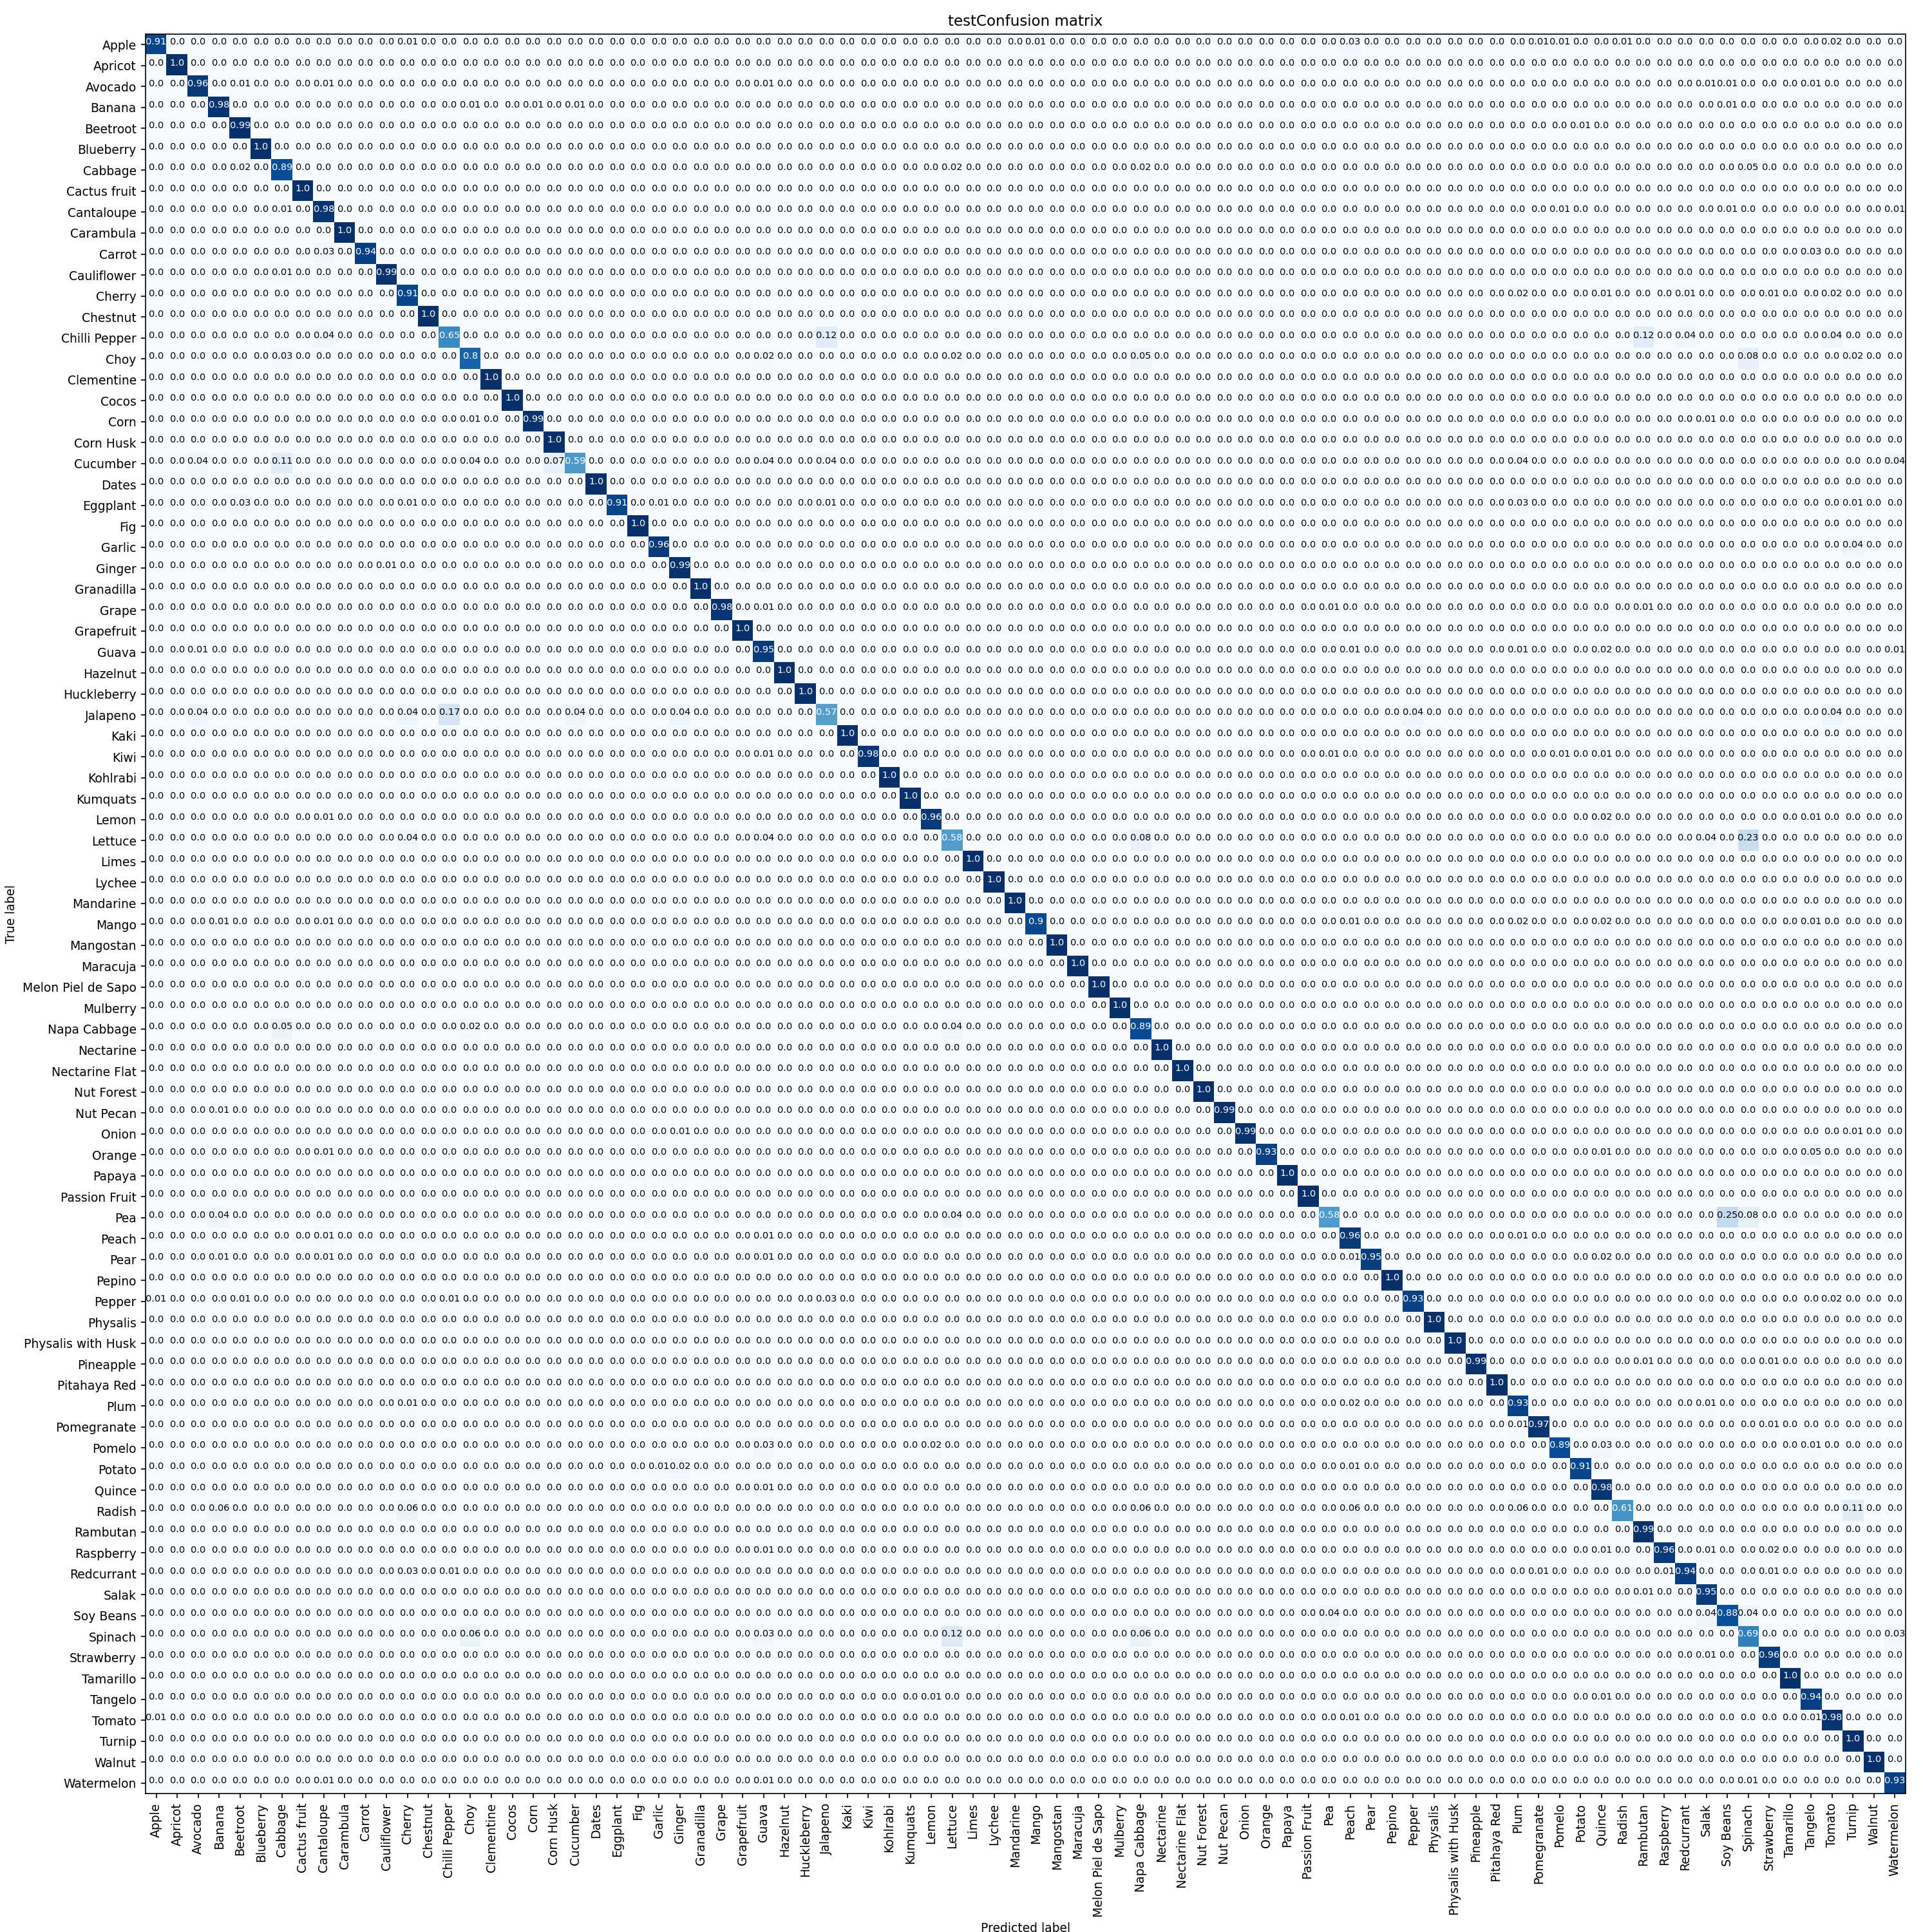

**Recording the results of each epoch Saving in train.log**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

with open('train.log') as f:
    mobilenetv2 = [i for i in list(map(lambda x:x.strip(), f.readlines())) if 'epoch' in i]

mobilenetv2 = [i.split(',') for i in mobilenetv2]
mobilenetv2 = np.array([np.array(list(map(lambda x:float(x.split(':')[1]), i[2:]))) for i in mobilenetv2])

plt.subplot(2, 2, 1)
plt.plot(list(range(len(mobilenetv2))), mobilenetv2[:, 0])
plt.title('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(list(range(len(mobilenetv2))), mobilenetv2[:, 1])
plt.title('val_loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(list(range(len(mobilenetv2))), mobilenetv2[:, 2])
plt.title('acc')
plt.xlabel('epoch')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(list(range(len(mobilenetv2))), mobilenetv2[:, 3])
plt.title('val_acc')
plt.xlabel('epoch')
plt.legend()

plt.show()

# *train.log*

2021-04-08 00:03:11 epoch:1, time:1430.47s, train_loss:0.70944, val_loss:0.23707, train_acc:0.8224, val_acc:0.9321
2021-04-08 00:25:59 epoch:2, time:1368.65s, train_loss:0.35587, val_loss:0.24335, train_acc:0.9054, val_acc:0.9336
2021-04-08 00:48:20 epoch:3, time:1340.75s, train_loss:0.32349, val_loss:0.23386, train_acc:0.9132, val_acc:0.9360
2021-04-08 01:10:52 epoch:4, time:1352.00s, train_loss:0.30966, val_loss:0.19772, train_acc:0.9178, val_acc:0.9460
2021-04-08 01:33:09 epoch:5, time:1336.91s, train_loss:0.29049, val_loss:0.19974, train_acc:0.9235, val_acc:0.9477
2021-04-08 01:55:39 epoch:6, time:1349.37s, train_loss:0.28824, val_loss:0.19192, train_acc:0.9244, val_acc:0.9449
2021-04-08 02:18:11 epoch:7, time:1352.04s, train_loss:0.28993, val_loss:0.19890, train_acc:0.9247, val_acc:0.9463
2021-04-08 02:40:50 epoch:8, time:1358.61s, train_loss:0.27888, val_loss:0.22187, train_acc:0.9287, val_acc:0.9405
2021-04-08 03:03:28 epoch:9, time:1357.43s, train_loss:0.27455, val_loss:0.19596, train_acc:0.9297, val_acc:0.9482
2021-04-08 03:25:58 epoch:10, time:1350.34s, train_loss:0.26742, val_loss:0.18216, train_acc:0.9306, val_acc:0.9498
2021-04-08 03:48:21 epoch:11, time:1342.69s, train_loss:0.24231, val_loss:0.17529, train_acc:0.9383, val_acc:0.9539
2021-04-08 04:11:03 epoch:12, time:1362.38s, train_loss:0.23136, val_loss:0.16422, train_acc:0.9414, val_acc:0.9554
2021-04-08 04:33:39 epoch:13, time:1355.66s, train_loss:0.23835, val_loss:0.18773, train_acc:0.9403, val_acc:0.9481
2021-04-08 04:56:25 epoch:14, time:1365.24s, train_loss:0.22234, val_loss:0.17832, train_acc:0.9449, val_acc:0.9521
2021-04-08 05:18:53 epoch:15, time:1348.28s, train_loss:0.22420, val_loss:0.15981, train_acc:0.9425, val_acc:0.9580
2021-04-08 05:41:51 epoch:16, time:1377.50s, train_loss:0.22477, val_loss:0.16035, train_acc:0.9426, val_acc:0.9577
2021-04-08 06:04:18 epoch:17, time:1347.10s, train_loss:0.22471, val_loss:0.21910, train_acc:0.9423, val_acc:0.9488
2021-04-08 06:27:22 epoch:18, time:1383.62s, train_loss:0.21393, val_loss:0.19718, train_acc:0.9471, val_acc:0.9518
2021-04-08 06:49:41 epoch:19, time:1339.18s, train_loss:0.21671, val_loss:0.16248, train_acc:0.9445, val_acc:0.9566
2021-04-08 07:12:15 epoch:20, time:1353.22s, train_loss:0.20948, val_loss:0.19286, train_acc:0.9474, val_acc:0.9506
2021-04-08 07:35:03 epoch:21, time:1367.73s, train_loss:0.19245, val_loss:0.16293, train_acc:0.9505, val_acc:0.9551
2021-04-08 07:57:39 epoch:22, time:1355.77s, train_loss:0.18980, val_loss:0.19777, train_acc:0.9516, val_acc:0.9504
2021-04-08 08:20:12 epoch:23, time:1352.88s, train_loss:0.19222, val_loss:0.16752, train_acc:0.9513, val_acc:0.9578
2021-04-08 08:43:03 epoch:24, time:1371.05s, train_loss:0.19912, val_loss:0.15835, train_acc:0.9493, val_acc:0.9567
2021-04-08 09:05:51 epoch:25, time:1367.84s, train_loss:0.18248, val_loss:0.16770, train_acc:0.9548, val_acc:0.9557
2021-04-08 09:28:23 epoch:26, time:1352.19s, train_loss:0.19165, val_loss:0.19258, train_acc:0.9517, val_acc:0.9483
2021-04-08 09:51:08 epoch:27, time:1364.40s, train_loss:0.18772, val_loss:0.15992, train_acc:0.9539, val_acc:0.9560
2021-04-08 10:13:40 epoch:28, time:1351.98s, train_loss:0.18619, val_loss:0.18138, train_acc:0.9526, val_acc:0.9510
2021-04-08 10:36:27 epoch:29, time:1367.03s, train_loss:0.19092, val_loss:0.16752, train_acc:0.9522, val_acc:0.9545
2021-04-08 10:58:58 epoch:30, time:1350.56s, train_loss:0.18887, val_loss:0.16427, train_acc:0.9516, val_acc:0.9559
2021-04-08 11:21:49 epoch:31, time:1370.66s, train_loss:0.16847, val_loss:0.14679, train_acc:0.9573, val_acc:0.9617
2021-04-08 11:44:50 epoch:32, time:1381.13s, train_loss:0.16963, val_loss:0.15240, train_acc:0.9572, val_acc:0.9587
2021-04-08 12:07:25 epoch:33, time:1354.86s, train_loss:0.16870, val_loss:0.16665, train_acc:0.9571, val_acc:0.9563
2021-04-08 12:29:57 epoch:34, time:1352.02s, train_loss:0.16156, val_loss:0.17184, train_acc:0.9598, val_acc:0.9557
2021-04-08 12:52:54 epoch:35, time:1376.26s, train_loss:0.16646, val_loss:0.16905, train_acc:0.9586, val_acc:0.9561
2021-04-08 13:15:06 epoch:36, time:1331.44s, train_loss:0.16764, val_loss:0.14850, train_acc:0.9589, val_acc:0.9593
2021-04-08 13:37:47 epoch:37, time:1361.02s, train_loss:0.16673, val_loss:0.15277, train_acc:0.9584, val_acc:0.9616
2021-04-08 14:00:11 epoch:38, time:1344.06s, train_loss:0.16103, val_loss:0.15050, train_acc:0.9604, val_acc:0.9590
2021-04-08 14:22:45 epoch:39, time:1353.35s, train_loss:0.16702, val_loss:0.14786, train_acc:0.9574, val_acc:0.9614
2021-04-08 14:44:56 epoch:40, time:1331.46s, train_loss:0.16122, val_loss:0.14376, train_acc:0.9609, val_acc:0.9613
2021-04-08 15:07:18 epoch:41, time:1341.60s, train_loss:0.15035, val_loss:0.15082, train_acc:0.9642, val_acc:0.9617
2021-04-08 15:29:43 epoch:42, time:1345.15s, train_loss:0.14810, val_loss:0.14332, train_acc:0.9638, val_acc:0.9638
2021-04-08 15:52:24 epoch:43, time:1361.05s, train_loss:0.15002, val_loss:0.14218, train_acc:0.9624, val_acc:0.9615
2021-04-08 16:15:08 epoch:44, time:1363.82s, train_loss:0.15087, val_loss:0.14702, train_acc:0.9631, val_acc:0.9617
2021-04-08 16:37:55 epoch:45, time:1366.08s, train_loss:0.15408, val_loss:0.16405, train_acc:0.9624, val_acc:0.9581
2021-04-08 17:00:14 epoch:46, time:1339.41s, train_loss:0.14574, val_loss:0.15246, train_acc:0.9648, val_acc:0.9603
2021-04-08 17:22:51 epoch:47, time:1356.96s, train_loss:0.15290, val_loss:0.17467, train_acc:0.9620, val_acc:0.9587
2021-04-08 17:45:11 epoch:48, time:1339.38s, train_loss:0.15021, val_loss:0.15658, train_acc:0.9631, val_acc:0.9604
2021-04-08 18:07:37 epoch:49, time:1345.77s, train_loss:0.14431, val_loss:0.14133, train_acc:0.9650, val_acc:0.9615
2021-04-08 18:30:10 epoch:50, time:1353.00s, train_loss:0.14949, val_loss:0.16151, train_acc:0.9639, val_acc:0.9585
2021-04-08 18:52:57 epoch:51, time:1366.29s, train_loss:0.13183, val_loss:0.13336, train_acc:0.9687, val_acc:0.9647
2021-04-08 19:15:45 epoch:52, time:1367.90s, train_loss:0.13064, val_loss:0.15459, train_acc:0.9686, val_acc:0.9611
2021-04-08 19:38:01 epoch:53, time:1336.57s, train_loss:0.13192, val_loss:0.15252, train_acc:0.9691, val_acc:0.9607
2021-04-08 20:00:55 epoch:54, time:1372.96s, train_loss:0.13668, val_loss:0.14539, train_acc:0.9665, val_acc:0.9617
2021-04-08 20:23:48 epoch:55, time:1373.25s, train_loss:0.13930, val_loss:0.17586, train_acc:0.9664, val_acc:0.9517
2021-04-08 20:46:11 epoch:56, time:1342.39s, train_loss:0.13592, val_loss:0.14362, train_acc:0.9676, val_acc:0.9627
2021-04-08 21:09:19 epoch:57, time:1388.30s, train_loss:0.13897, val_loss:0.14267, train_acc:0.9664, val_acc:0.9633
2021-04-08 21:31:47 epoch:58, time:1347.63s, train_loss:0.12810, val_loss:0.15832, train_acc:0.9693, val_acc:0.9588
2021-04-08 21:54:11 epoch:59, time:1343.88s, train_loss:0.13439, val_loss:0.14454, train_acc:0.9674, val_acc:0.9622
2021-04-08 22:16:46 epoch:60, time:1354.86s, train_loss:0.12976, val_loss:0.14383, train_acc:0.9692, val_acc:0.9639
2021-04-08 22:39:25 epoch:61, time:1358.81s, train_loss:0.11708, val_loss:0.14808, train_acc:0.9719, val_acc:0.9643
2021-04-08 23:02:16 epoch:62, time:1370.89s, train_loss:0.11976, val_loss:0.14901, train_acc:0.9721, val_acc:0.9613
2021-04-08 23:25:09 epoch:63, time:1372.38s, train_loss:0.12280, val_loss:0.13948, train_acc:0.9699, val_acc:0.9631
2021-04-08 23:48:49 epoch:64, time:1420.07s, train_loss:0.12152, val_loss:0.14710, train_acc:0.9716, val_acc:0.9619
2021-04-09 00:12:18 epoch:65, time:1408.81s, train_loss:0.12228, val_loss:0.15746, train_acc:0.9704, val_acc:0.9618
2021-04-09 00:35:09 epoch:66, time:1371.21s, train_loss:0.12051, val_loss:0.14139, train_acc:0.9716, val_acc:0.9635
2021-04-09 00:58:09 epoch:67, time:1378.96s, train_loss:0.11502, val_loss:0.14771, train_acc:0.9732, val_acc:0.9631
2021-04-09 01:20:43 epoch:68, time:1354.62s, train_loss:0.12151, val_loss:0.15770, train_acc:0.9713, val_acc:0.9604
2021-04-09 01:43:28 epoch:69, time:1364.04s, train_loss:0.12061, val_loss:0.14813, train_acc:0.9720, val_acc:0.9632
2021-04-09 02:06:08 epoch:70, time:1360.34s, train_loss:0.12569, val_loss:0.14649, train_acc:0.9699, val_acc:0.9633
2021-04-09 02:28:57 epoch:71, time:1368.29s, train_loss:0.10618, val_loss:0.16206, train_acc:0.9750, val_acc:0.9606
2021-04-09 02:51:40 epoch:72, time:1363.59s, train_loss:0.11239, val_loss:0.14190, train_acc:0.9746, val_acc:0.9640
2021-04-09 03:14:01 epoch:73, time:1340.19s, train_loss:0.10898, val_loss:0.14029, train_acc:0.9749, val_acc:0.9649
2021-04-09 03:37:14 epoch:74, time:1393.27s, train_loss:0.11240, val_loss:0.13233, train_acc:0.9734, val_acc:0.9665
2021-04-09 03:59:17 epoch:75, time:1322.92s, train_loss:0.10828, val_loss:0.13142, train_acc:0.9743, val_acc:0.9661
2021-04-09 04:21:29 epoch:76, time:1332.00s, train_loss:0.10716, val_loss:0.14561, train_acc:0.9749, val_acc:0.9647
2021-04-09 04:44:16 epoch:77, time:1366.17s, train_loss:0.10952, val_loss:0.14202, train_acc:0.9749, val_acc:0.9650
2021-04-09 05:06:48 epoch:78, time:1351.62s, train_loss:0.11099, val_loss:0.15118, train_acc:0.9735, val_acc:0.9616
2021-04-09 05:29:32 epoch:79, time:1364.56s, train_loss:0.10640, val_loss:0.14801, train_acc:0.9752, val_acc:0.9637
2021-04-09 05:52:34 epoch:80, time:1381.08s, train_loss:0.10765, val_loss:0.13689, train_acc:0.9759, val_acc:0.9653
2021-04-09 06:14:22 epoch:81, time:1308.05s, train_loss:0.09921, val_loss:0.14991, train_acc:0.9762, val_acc:0.9635
2021-04-09 06:37:10 epoch:82, time:1368.29s, train_loss:0.09837, val_loss:0.14161, train_acc:0.9776, val_acc:0.9653
2021-04-09 06:59:57 epoch:83, time:1366.06s, train_loss:0.09465, val_loss:0.14134, train_acc:0.9795, val_acc:0.9672
2021-04-09 07:22:37 epoch:84, time:1360.53s, train_loss:0.10223, val_loss:0.13930, train_acc:0.9762, val_acc:0.9644
2021-04-09 07:46:45 epoch:85, time:1447.70s, train_loss:0.10713, val_loss:0.13986, train_acc:0.9761, val_acc:0.9651
**2021-04-09 08:10:10 epoch:86, time:1404.41s, train_loss:0.09470, val_loss:0.13487, train_acc:0.9790, val_acc:0.9673**
2021-04-09 08:32:49 epoch:87, time:1358.64s, train_loss:0.10056, val_loss:0.16346, train_acc:0.9780, val_acc:0.9623
2021-04-09 08:55:21 epoch:88, time:1352.36s, train_loss:0.10235, val_loss:0.13973, train_acc:0.9772, val_acc:0.9644
2021-04-09 09:17:57 epoch:89, time:1356.10s, train_loss:0.09717, val_loss:0.15248, train_acc:0.9777, val_acc:0.9626
2021-04-09 09:40:32 epoch:90, time:1354.42s, train_loss:0.09899, val_loss:0.14444, train_acc:0.9776, val_acc:0.9627
2021-04-09 10:03:05 epoch:91, time:1352.63s, train_loss:0.09258, val_loss:0.14924, train_acc:0.9794, val_acc:0.9633
2021-04-09 10:25:53 epoch:92, time:1367.77s, train_loss:0.09178, val_loss:0.13275, train_acc:0.9799, val_acc:0.9660
2021-04-09 10:48:23 epoch:93, time:1349.97s, train_loss:0.08384, val_loss:0.15411, train_acc:0.9813, val_acc:0.9642
2021-04-09 11:10:44 epoch:94, time:1341.12s, train_loss:0.09683, val_loss:0.12995, train_acc:0.9783, val_acc:0.9672
2021-04-09 11:33:19 epoch:95, time:1354.28s, train_loss:0.08952, val_loss:0.13484, train_acc:0.9806, val_acc:0.9661
2021-04-09 11:56:13 epoch:96, time:1374.32s, train_loss:0.09069, val_loss:0.14284, train_acc:0.9807, val_acc:0.9648
2021-04-09 12:18:47 epoch:97, time:1353.28s, train_loss:0.08991, val_loss:0.15945, train_acc:0.9797, val_acc:0.9623
2021-04-09 12:41:30 epoch:98, time:1363.10s, train_loss:0.08616, val_loss:0.14901, train_acc:0.9813, val_acc:0.9621
2021-04-09 13:03:54 epoch:99, time:1343.91s, train_loss:0.09104, val_loss:0.15742, train_acc:0.9803, val_acc:0.9617
2021-04-09 13:26:37 epoch:100, time:1363.11s, train_loss:0.08876, val_loss:0.13966, train_acc:0.9810, val_acc:0.9647


# *result.txt*

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       199
           1       1.00      1.00      1.00       147
           2       0.96      0.96      0.96       171
           3       0.97      0.98      0.97       180
           4       0.94      0.99      0.97       172
           5       1.00      1.00      1.00       138
           6       0.75      0.89      0.81        44
           7       1.00      1.00      1.00       147
           8       0.91      0.98      0.94       185
           9       1.00      1.00      1.00       147
          10       0.94      0.94      0.94        33
          11       0.99      0.99      0.99       169
          12       0.93      0.91      0.92       219
          13       1.00      1.00      1.00       135
          14       0.65      0.65      0.65        26
          15       0.89      0.80      0.84        64
          16       1.00      1.00      1.00       147
          17       1.00      1.00      1.00       147
          18       0.99      0.99      0.99       183
          19       0.99      1.00      0.99       138
          20       0.89      0.59      0.71        27
          21       1.00      1.00      1.00       147
          22       1.00      0.91      0.95       167
          23       1.00      1.00      1.00       150
          24       0.86      0.96      0.91        26
          25       0.94      0.99      0.96       104
          26       1.00      1.00      1.00       147
          27       0.99      0.98      0.98       177
          28       1.00      1.00      1.00       150
          29       0.90      0.95      0.92       199
          30       1.00      1.00      1.00       139
          31       1.00      1.00      1.00       147
          32       0.57      0.57      0.57        23
          33       1.00      1.00      1.00       147
          34       0.99      0.98      0.98       164
          35       1.00      1.00      1.00       141
          36       1.00      1.00      1.00       147
          37       0.96      0.96      0.96       164
          38       0.62      0.58      0.60        26
          39       1.00      1.00      1.00       147
          40       1.00      1.00      1.00       147
          41       1.00      1.00      1.00       147
          42       0.99      0.90      0.94       168
          43       1.00      1.00      1.00        90
          44       1.00      1.00      1.00       147
          45       1.00      1.00      1.00       150
          46       1.00      1.00      1.00       147
          47       0.85      0.89      0.87        56
          48       1.00      1.00      1.00       147
          49       1.00      1.00      1.00       144
          50       1.00      1.00      1.00       150
          51       1.00      0.99      1.00       150
          52       1.00      0.99      0.99       168
          53       0.99      0.93      0.96       158
          54       1.00      1.00      1.00       147
          55       1.00      1.00      1.00       147
          56       0.82      0.58      0.68        24
          57       0.90      0.96      0.93       216
          58       0.99      0.95      0.97       172
          59       1.00      1.00      1.00       147
          60       0.99      0.93      0.96       174
          61       1.00      1.00      1.00       147
          62       1.00      1.00      1.00       147
          63       0.99      0.99      0.99       168
          64       1.00      1.00      1.00       147
          65       0.90      0.93      0.91       225
          66       0.98      0.97      0.98       222
          67       0.98      0.89      0.93       207
          68       0.98      0.91      0.95       206
          69       0.87      0.98      0.92       210
          70       0.92      0.61      0.73        18
          71       0.93      0.99      0.96       214
          72       0.99      0.96      0.98       190
          73       0.97      0.94      0.96       198
          74       0.94      0.95      0.95       223
          75       0.66      0.88      0.75        24
          76       0.54      0.69      0.60        32
          77       0.95      0.96      0.95       204
          78       1.00      1.00      1.00       147
          79       0.92      0.94      0.93       212
          80       0.92      0.98      0.95       176
          81       0.79      1.00      0.89        27
          82       1.00      1.00      1.00       150
          83       0.96      0.93      0.95       207

    accuracy                           0.97     12027
   macro avg       0.94      0.94      0.94     12027
weighted avg       0.97      0.97      0.97     12027

**Simple test program, with the best saved model**

In [ ]:
import os, cv2, torch
import numpy as np

if __name__ == '__main__':
    with open('classes.txt') as f:
        label = list(map(lambda x:x.strip(), f.readlines()))

    #DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    DEVICE = torch.device("cpu")
    print(DEVICE)

    model = torch.load('model.pht').to(DEVICE)

    while True:
        img_path = input('Imput Image Path:')
        try:
            img = cv2.imdecode(np.fromfile(img_path, np.uint8), cv2.IMREAD_COLOR)
            img = cv2.resize(img, (224, 224))
            img = np.transpose(img, axes=[2, 0, 1]) / 255.0
            img = np.expand_dims(img, axis=0)
            img = torch.from_numpy(img).to(DEVICE).float()
            pred = np.argmax(model(img).cpu().detach().numpy()[0])
            print('Image Path:{}, Pred Class:{}'.format(img_path, label[pred]))
        except:
            print('Error, Try Again!')


### **model.pht is the model trained after epoch 86**
